In [1]:
import fitness.data_generating_process as dgp

%matplotlib inline

import matplotlib.pyplot as plt

def create_histogram(data, data_var_list):
    # Number of histograms to plot
    num_histograms = len(data_var_list)

    # Create subplots
    fig, axs = plt.subplots(1, num_histograms, figsize=(20, 5))

    data = np.array(data)
    # Plot each histogram
    for i in range(num_histograms):
        values = np.unique(data[:,i])
        axs[i].hist(data[:,i], bins=[ -0.5 + i for i in range(int(min(values)), int(max(values))+2)], density=True, stacked=True, alpha=0.7, color='blue', rwidth=0.8)
        axs[i].set_title(data_var_list[i])
        axs[i].set_xlabel('Value')
        axs[i].set_ylabel('Frequency')

    # Adjust layout and show the plot
    plt.tight_layout()
    plt.show()

def create_histograms(data_list, name_list, data_var_list):
    # Number of histograms to plot
    num_histograms = len(data_var_list)

    # Create subplots
    fig, axs = plt.subplots(1, num_histograms, figsize=(20, 5))

    
    # Plot each histogram
    for i in range(num_histograms):

        # looks at the value for variables i in all data
        values_list = []
        for data in data_list:
            data = np.array(data)
            values_list.append(np.unique(data[:,i]))
        values = np.unique(np.concatenate(values_list))
        bins = [ -0.5 + i for i in range(int(min(values)), int(max(values))+2)]
        
        # creates the histograms 
        hist_list = [np.histogram(data, bins=bins, density=True)[0] for data in data_list]

        # Define the positions for the bars
        bar_width = 0.25
        r = np.arange(len(hist_list[0]))
        positions = [r + i * bar_width for i in range(len(data_list))]

        # Create the bar plot
        for k, hist in enumerate(hist_list):
            axs[i].bar(positions[k], hist, width=bar_width, edgecolor='grey', label=name_list[k])
        axs[i].set_title(data_var_list[i])
        axs[i].set_xlabel('Value')
        axs[i].set_ylabel('Frequency')

    # Adjust layout and show the plot
    plt.legend()
    plt.tight_layout()
    plt.show()


import numpy as np
from scipy.stats import multivariate_normal

def sample_gmm(dist, n_samples):
   
    n_components = dist.gm.n_comp()
    weights = dist.gm.pi
    means = dist.gm.mu
    covariances = dist.gm.sigma
    samples = []

    # Sample component indices based on weights
    component_indices = np.random.choice(n_components, size=n_samples, p=weights)

    for i in range(n_components):
        # Number of samples for this component
        n_samples_i = np.sum(component_indices == i)
        if n_samples_i > 0:
            # Sample from the i-th Gaussian component
            samples_i = multivariate_normal.rvs(mean=means[i], cov=covariances[i], size=n_samples_i)
            samples.append(samples_i)

    # Concatenate all samples
    samples = np.vstack(samples)
    np.random.shuffle(samples)  # Shuffle to mix samples from different components

    return samples

import torch
torch.set_default_dtype(torch.float64)
from fitness.soga_fitness_trueskills import *


# Burglary

In [345]:
model_name = 'burglary'

### Data from the original data generating process

In [335]:
"""

def generate_burglary_dataset(data_size):
    data = []
    for _ in range(data_size):
        burglary = np.random.binomial(1, 0.001)  # 0.001
        earthquake = np.random.binomial(1, 0.002) # 0.002
        if burglary:
            if earthquake:
                alarm = np.random.binomial(1, 0.95)
            else:
                alarm = np.random.binomial(1, 0.94)
        else:
            if earthquake:
                alarm = np.random.binomial(1, 0.29)
            else:
                alarm = np.random.binomial(1, 0.001) # 0.001
        if alarm:
            johncalls = np.random.binomial(1, 0.9)
        else:
            johncalls = np.random.binomial(1, 0.05)
        data.append([burglary, earthquake, alarm, johncalls])
    return data
    
"""

'\n\ndef generate_burglary_dataset(data_size):\n    data = []\n    for _ in range(data_size):\n        burglary = np.random.binomial(1, 0.001)  # 0.001\n        earthquake = np.random.binomial(1, 0.002) # 0.002\n        if burglary:\n            if earthquake:\n                alarm = np.random.binomial(1, 0.95)\n            else:\n                alarm = np.random.binomial(1, 0.94)\n        else:\n            if earthquake:\n                alarm = np.random.binomial(1, 0.29)\n            else:\n                alarm = np.random.binomial(1, 0.001) # 0.001\n        if alarm:\n            johncalls = np.random.binomial(1, 0.9)\n        else:\n            johncalls = np.random.binomial(1, 0.05)\n        data.append([burglary, earthquake, alarm, johncalls])\n    return data\n    \n'

In [336]:
data = dgp.generate_dataset(model_name, 5000)
data_var_list, dependencies, weights = dgp.get_vars(model_name)
print(data_var_list)

['burglary', 'earthquake', 'alarm', 'johncalls']


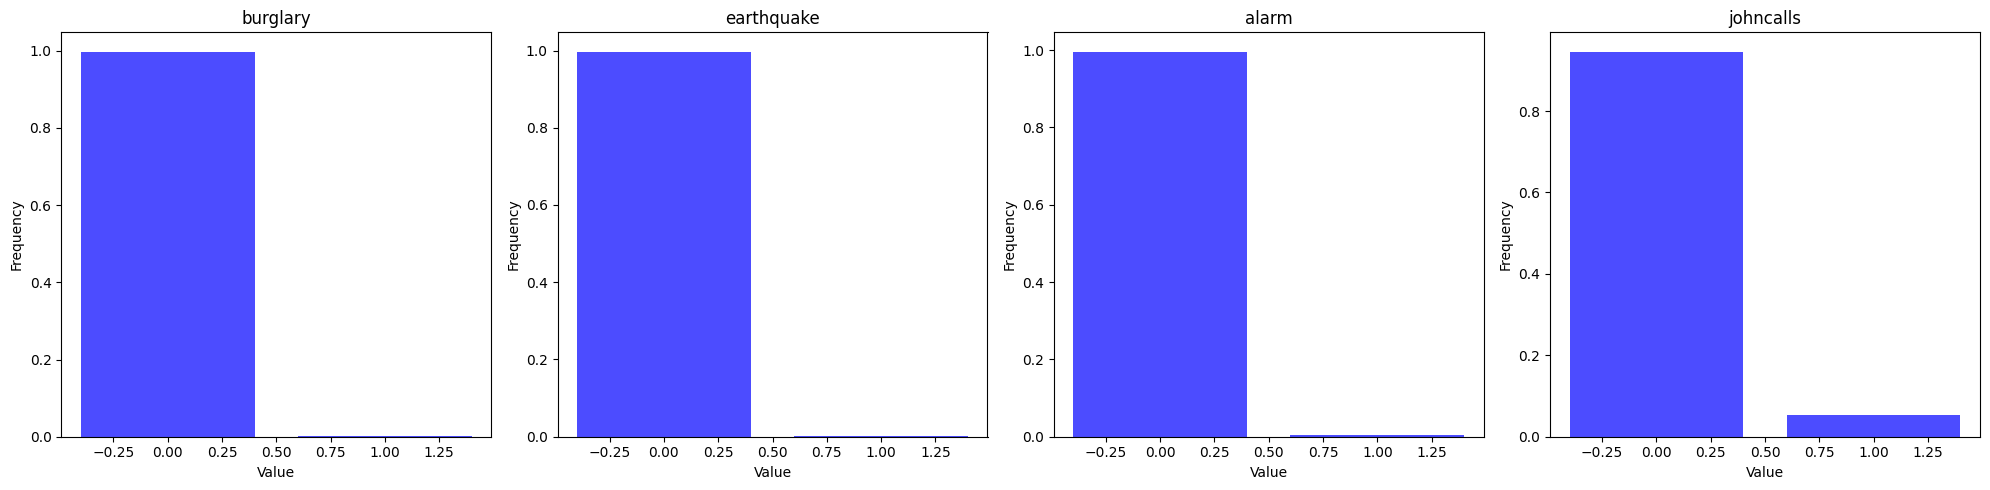

In [337]:
create_histogram(data, data_var_list)

In [338]:
file = open('C:/Users/birik/github/PonyGE2/baselines/'+model_name+'.soga', 'r')
text_baseline = ''
for line in file.readlines():
    text_baseline += line + ' '
file.close()

soga_bl = preprocess_program(text_baseline)
compiledText=compile2SOGA_text(soga_bl)
cfg = produce_cfg_text(compiledText)
output_dist_baseline = start_SOGA(cfg)

fitness_baseline = compute_likelihood(output_dist_baseline, data_var_list, data)
print(fitness_baseline)

tensor(-0.2592)


### No sketching

In [339]:
file = open("C:/Users/birik/github/PonyGE2/results/"+model_name+"/no-sketch1/best.txt", 'r')
text_bf = ''
flag = False
for line in file.readlines():
    if 'Phenotype' in line:
        flag = True
        continue
    if 'Genotype' in line:
        flag = False
        break
    if flag:
        text_bf += line + ' '
file.close()

soga_bf = preprocess_program(text_bf)
compiledText=compile2SOGA_text(soga_bf)
cfg = produce_cfg_text(compiledText)
output_dist = start_SOGA(cfg)

fitness_bf = compute_likelihood(output_dist, data_var_list, data)
print(fitness_bf)

tensor(-inf)


In [340]:
print('Fitness of best found program: ', fitness_bf)
print('Fitness of baseline: ', fitness_baseline)

print('Found Program \n', text_bf) 

Fitness of best found program:  tensor(-inf)
Fitness of baseline:  tensor(-0.2592)
Found Program 
 burglary = 4  * burglary  - 5  * earthquake; 
  earthquake = gm([0, 1, 0], [9, 0, 0]) + 6 * 8; 
  alarm = burglary; 
  johncalls = gm([0, 1, 0], [6, 0, 0]); 
  earthquake = 1  * burglary + burglary;
 
 


In [341]:
samples = sample_gmm(output_dist, 10000)

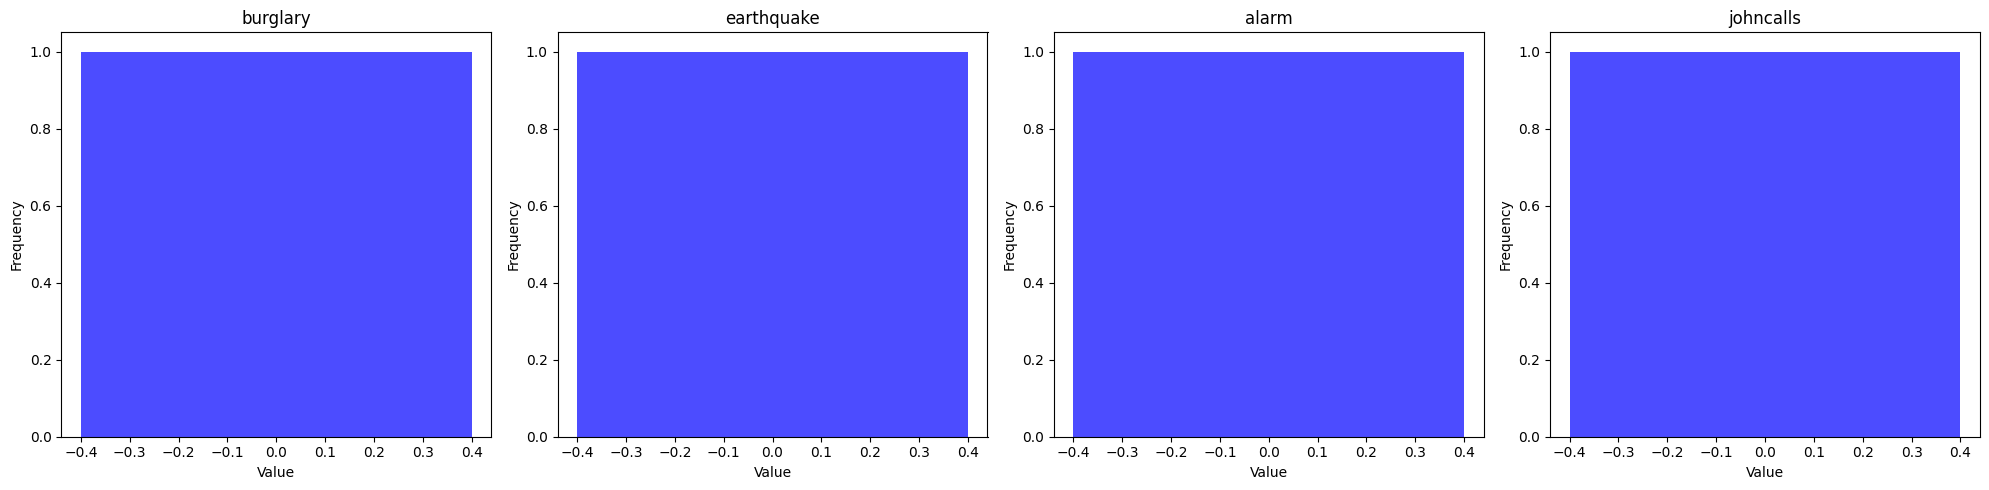

In [342]:
# histogram best found program
create_histogram(samples, output_dist.var_list)

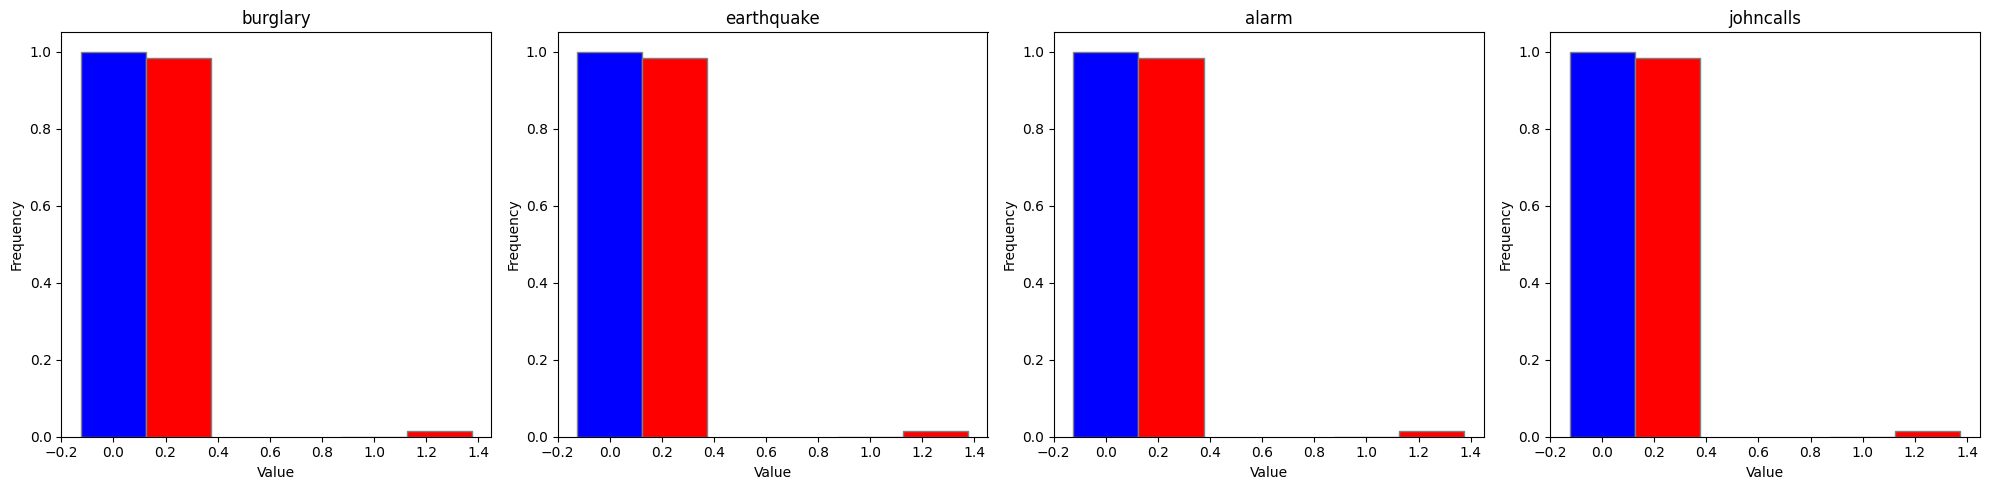

In [352]:
# original histogram
create_histograms([samples, data], ['best-found', 'original'], data_var_list)

### Sketching - no benefit

In [249]:
file = open("C:/Users/birik/github/PonyGE2/results/"+model_name+"/sketch-noben/best.txt", 'r')
text_bf = ''
flag = False
for line in file.readlines():
    if 'Phenotype' in line:
        flag = True
        continue
    if 'Genotype' in line:
        flag = False
        break
    if flag:
        text_bf += line + ' '
file.close()

soga_bf = preprocess_program(text_bf)
compiledText=compile2SOGA_text(soga_bf)
cfg = produce_cfg_text(compiledText)
output_dist = start_SOGA(cfg)

fitness_bf = compute_likelihood(output_dist, data_var_list, data)
print(fitness_bf)

tensor(-inf)


In [250]:
print('Fitness of best found program: ', fitness_bf)
print('Fitness of baseline: ', fitness_baseline)

print('Found Program \n', text_bf) 

Fitness of best found program:  tensor(-inf)
Fitness of baseline:  tensor(-0.2355)
Found Program 
 burglary = gm([2, 1, 0], [19, 0, 0]) + 30 * 0; 
  earthquake = 10  * johncalls + 11  * alarm; 
  if burglary == 1 { 
    if earthquake == 1 { 
      alarm = 23; 
    } else { 
      alarm = 8 + 3; 
    } end if; 
  } else { 
    if earthquake == 1 { 
      alarm = 7  * gm([5, 1, 0], [25, 0, 0]) + 4  * gm([30, 1, 0], [0, 0, 0]); 
    } else { 
      alarm = 10  * johncalls + 11  * alarm; 
    } end if; 
  } end if; 
  if alarm == 1 { 
    johncalls = 21  * johncalls  - johncalls; 
  } else { 
    johncalls = burglary + 25  * earthquake; 
  } end if;
 
 


In [251]:
samples = sample_gmm(output_dist, 5000)

values [0. 1.]
bins [-0.5, 0.5, 1.5]
values [0.]
bins [-0.5, 0.5]
values [0. 1.]
bins [-0.5, 0.5, 1.5]
values [ 0. 11.]
bins [-0.5, 0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5, 8.5, 9.5, 10.5, 11.5]


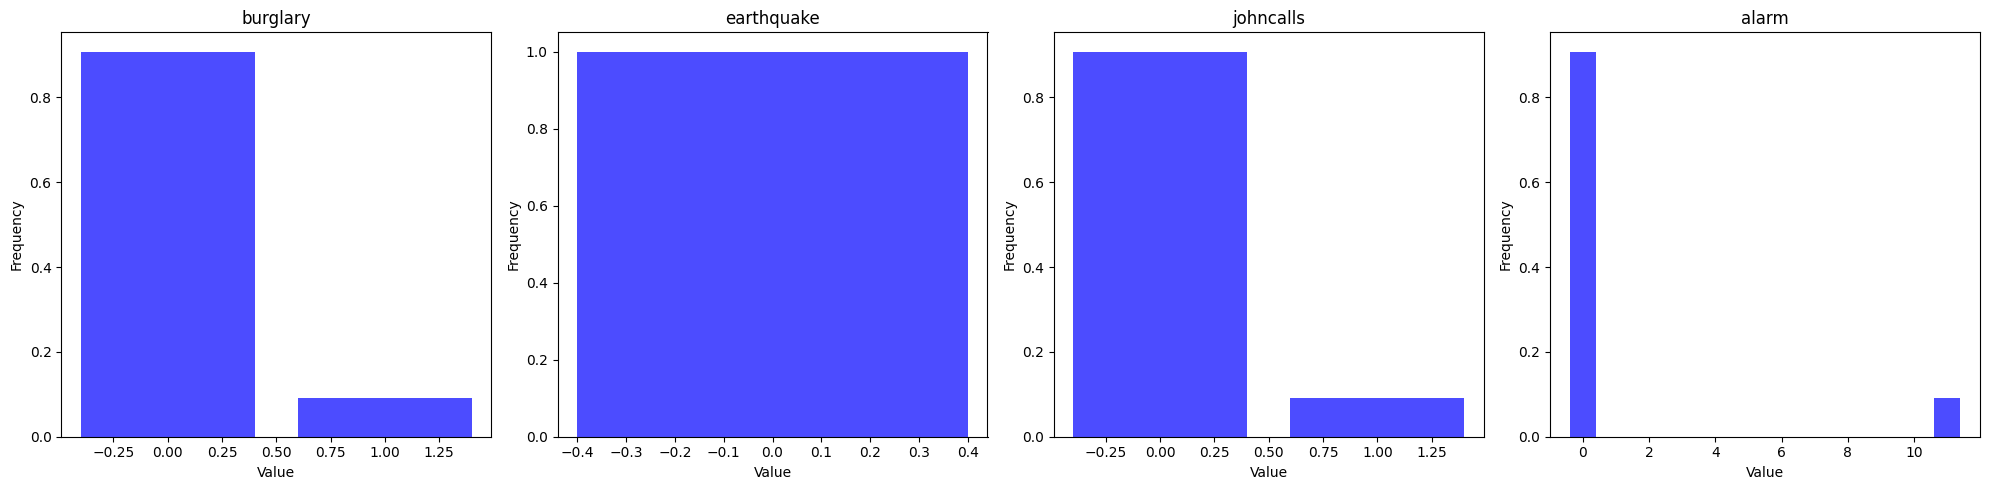

In [252]:
# histogram best found program
create_histograms(samples, output_dist.var_list)

values [0 1]
bins [-0.5, 0.5, 1.5]
values [0 1]
bins [-0.5, 0.5, 1.5]
values [0 1]
bins [-0.5, 0.5, 1.5]
values [0 1]
bins [-0.5, 0.5, 1.5]


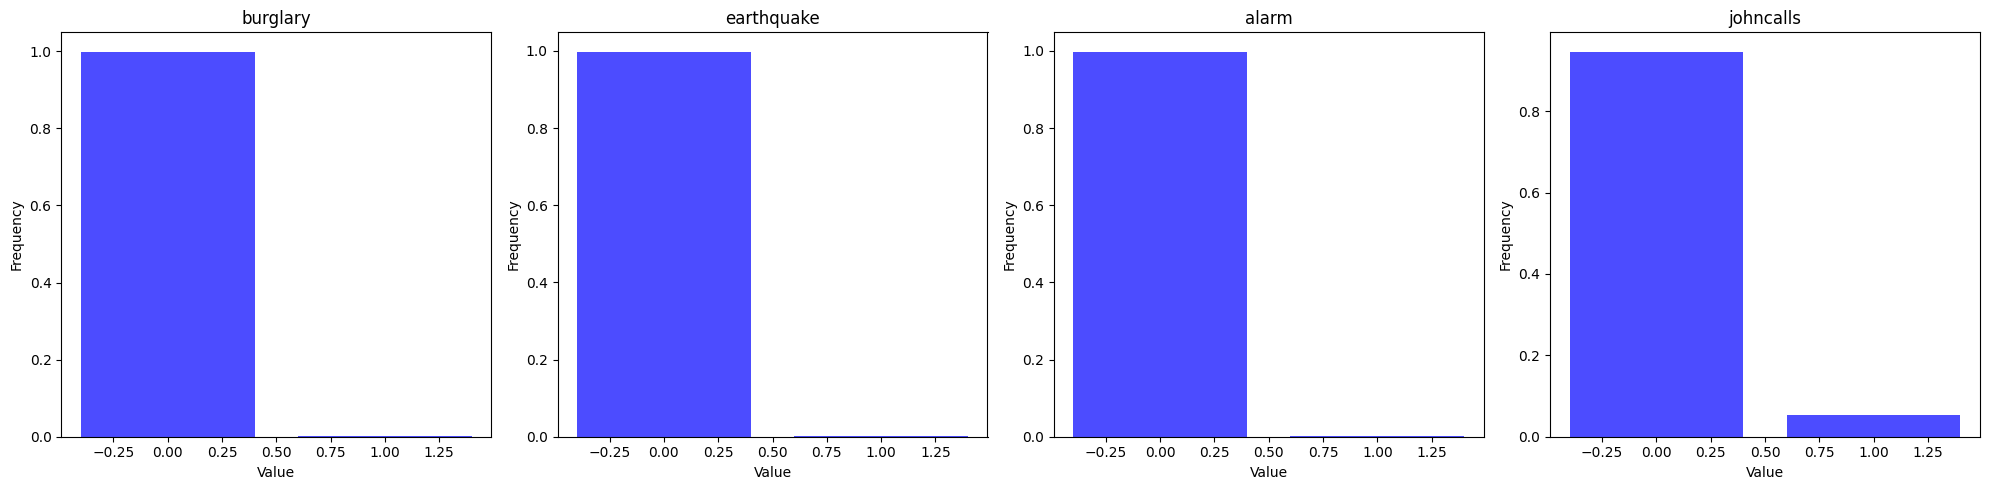

In [253]:
# original histogram
create_histograms(data, data_var_list)

# CSI

In [353]:
model_name = 'csi'

### Data from the original data generating process

In [354]:
"""
def generate_csi_dataset(data_size):
    data = []
    for _ in range(data_size):
        u = np.random.binomial(1, 0.3)
        v = np.random.binomial(1, 0.9)
        w = np.random.binomial(1, 0.1)
        if u:
            if w:
                x = np.random.binomial(1, 0.8)
            else:
                x = np.random.binomial(1, 0.2)
        else:
            if v:
                x = np.random.binomial(1, 0.8)
            else:
                x = np.random.binomial(1, 0.2)
        data.append([u, v, w, x])
    return data
"""

'\ndef generate_csi_dataset(data_size):\n    data = []\n    for _ in range(data_size):\n        u = np.random.binomial(1, 0.3)\n        v = np.random.binomial(1, 0.9)\n        w = np.random.binomial(1, 0.1)\n        if u:\n            if w:\n                x = np.random.binomial(1, 0.8)\n            else:\n                x = np.random.binomial(1, 0.2)\n        else:\n            if v:\n                x = np.random.binomial(1, 0.8)\n            else:\n                x = np.random.binomial(1, 0.2)\n        data.append([u, v, w, x])\n    return data\n'

In [355]:
data = dgp.generate_dataset('csi', 5000)
data_var_list, dependencies, weights = dgp.get_vars('csi')

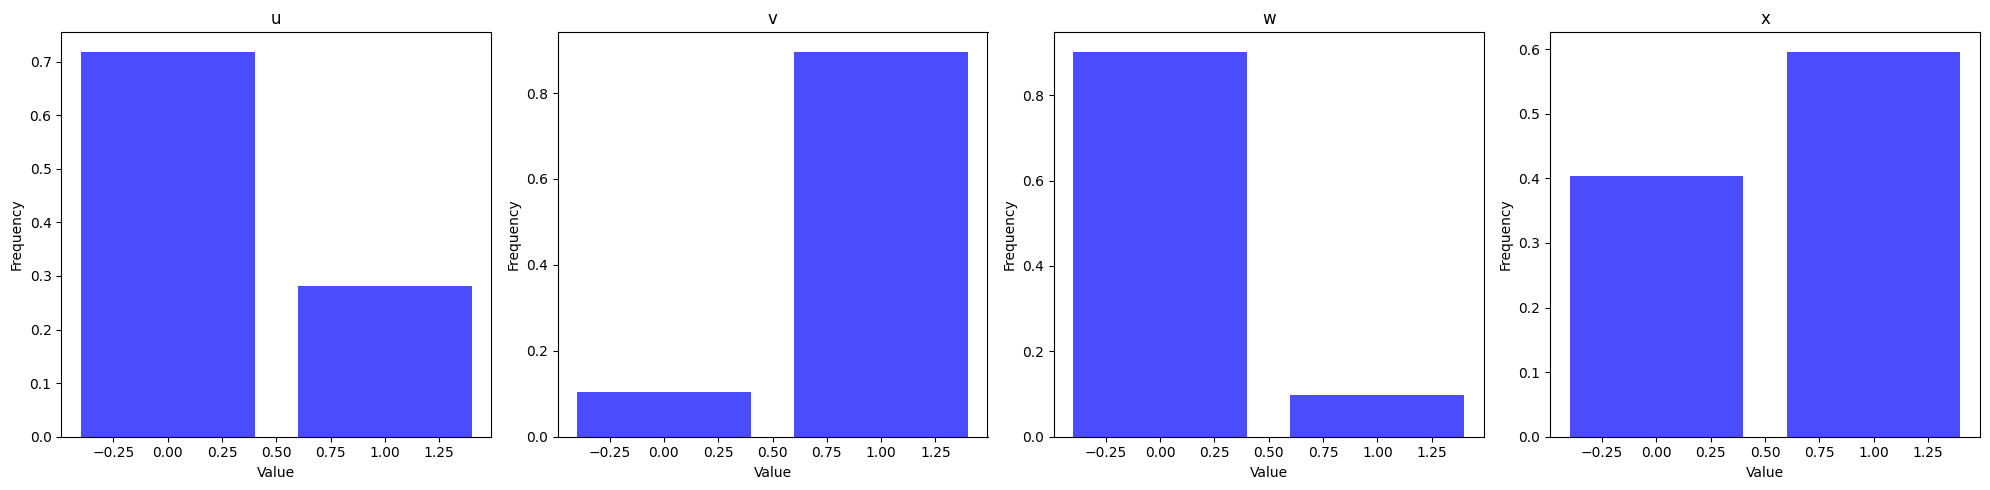

In [356]:
create_histogram(data, data_var_list)

In [357]:
file = open('C:/Users/birik/github/PonyGE2/baselines/'+model_name+'.soga', 'r')
text_baseline = ''
for line in file.readlines():
    text_baseline += line + ' '
file.close()

soga_bl = preprocess_program(text_baseline)
compiledText=compile2SOGA_text(soga_bl)
cfg = produce_cfg_text(compiledText)
output_dist_baseline = start_SOGA(cfg)

fitness_baseline = compute_likelihood(output_dist_baseline, data_var_list, data)
print(fitness_baseline)

tensor(-1.7547)


### No sketching

In [366]:
file = open("C:/Users/birik/github/PonyGE2/results/"+model_name+"/no-sketch1/best.txt", 'r')
text_bf = ''
flag = False
for line in file.readlines():
    if 'Phenotype' in line:
        flag = True
        continue
    if 'Genotype' in line:
        flag = False
        break
    if flag:
        text_bf += line + ' '
file.close()

soga_bf = preprocess_program(text_bf)
compiledText=compile2SOGA_text(soga_bf)
cfg = produce_cfg_text(compiledText)
output_dist = start_SOGA(cfg)

fitness_bf = compute_likelihood(output_dist, data_var_list, data)
print(fitness_bf)

tensor(-inf)


In [367]:
print('Fitness of best found program: ', fitness_bf)
print('Fitness of baseline: ', fitness_baseline)

print('Found Program \n', text_bf) 

Fitness of best found program:  tensor(-inf)
Fitness of baseline:  tensor(-1.7547)
Found Program 
 u = gm([11, 1, 0], [22, 0, 0]) + gm([1, 1, 0], [28, 0, 0]); 
  v = v + gm([25, 1, 0], [10, 0, 0]); 
  w = gm([14, 1, 0], [30, 0, 0]); 
  if u == 1 { 
    if w == 1 { 
      x = gm([8, 1, 0], [21, 0, 0]); 
    } else { 
      x = 1  * w + gm([2, 1, 0], [11, 0, 0]); 
    }end if; 
  } else { 
    if v == 1 { 
      x = gm([3, 1, 0], [1, 0, 0]); 
    } else { 
      x = x + v; 
    }end if; 
  }end if;
 
 


In [368]:
samples = sample_gmm(output_dist, 5000)

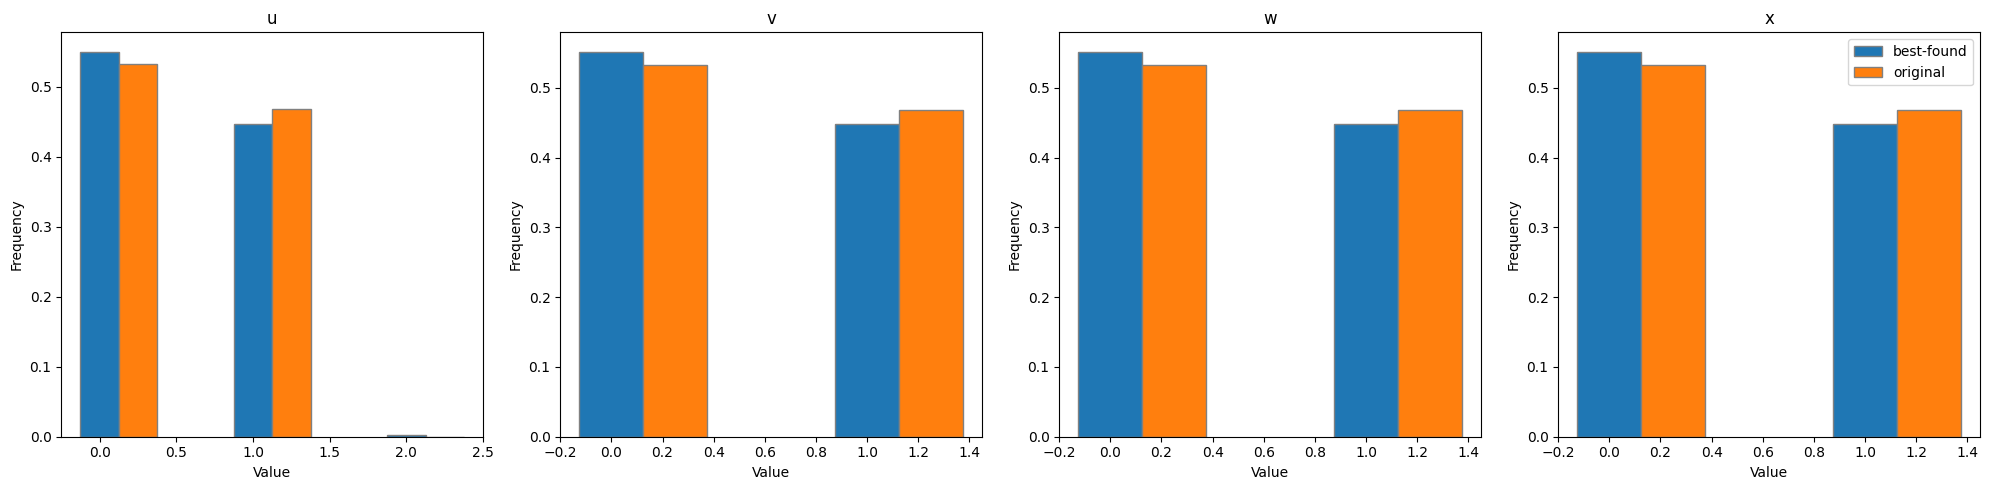

In [369]:
# data from best found
create_histograms([samples, data], ['best-found', 'original'], output_dist.var_list)

### Sketching - no benefit

In [370]:
file = open("C:/Users/birik/github/PonyGE2/results/"+model_name+"/sketch-noben1/best.txt", 'r')
text_bf = ''
flag = False
for line in file.readlines():
    if 'Phenotype' in line:
        flag = True
        continue
    if 'Genotype' in line:
        flag = False
        break
    if flag:
        text_bf += line + ' '
file.close()

soga_bf = preprocess_program(text_bf)
compiledText=compile2SOGA_text(soga_bf)
cfg = produce_cfg_text(compiledText)
output_dist = start_SOGA(cfg)

fitness_bf = compute_likelihood(output_dist, data_var_list, data)
print(fitness_bf)

tensor(-1.8900)


In [372]:
print('Fitness of best found program: ', fitness_bf)
print('Fitness of baseline: ', fitness_baseline)

print('Found Program \n', text_bf) 

Fitness of best found program:  tensor(-1.8900)
Fitness of baseline:  tensor(-1.7547)
Found Program 
 u = 0  * gm([7, 1, 0], [29, 0, 0]) + gm([17, 1, 0], [29, 0, 0]); 
  v = gm([24, 1, 0], [5, 0, 0]); 
  w = gm([1, 1, 0], [24, 0, 0]); 
  if u == 1 { 
    if w == 1 { 
      x = gm([12, 1, 0], [7, 0, 0]); 
    } else { 
      x = gm([15, 1, 0], [13, 0, 0])  - x; 
    }end if; 
  } else { 
    if v == 1 { 
      x = gm([27, 1, 0], [6, 0, 0]); 
    } else { 
      x = gm([13, 1, 0], [22, 0, 0]); 
    }end if; 
  }end if;
 
 


In [373]:
samples = sample_gmm(output_dist, 10000)

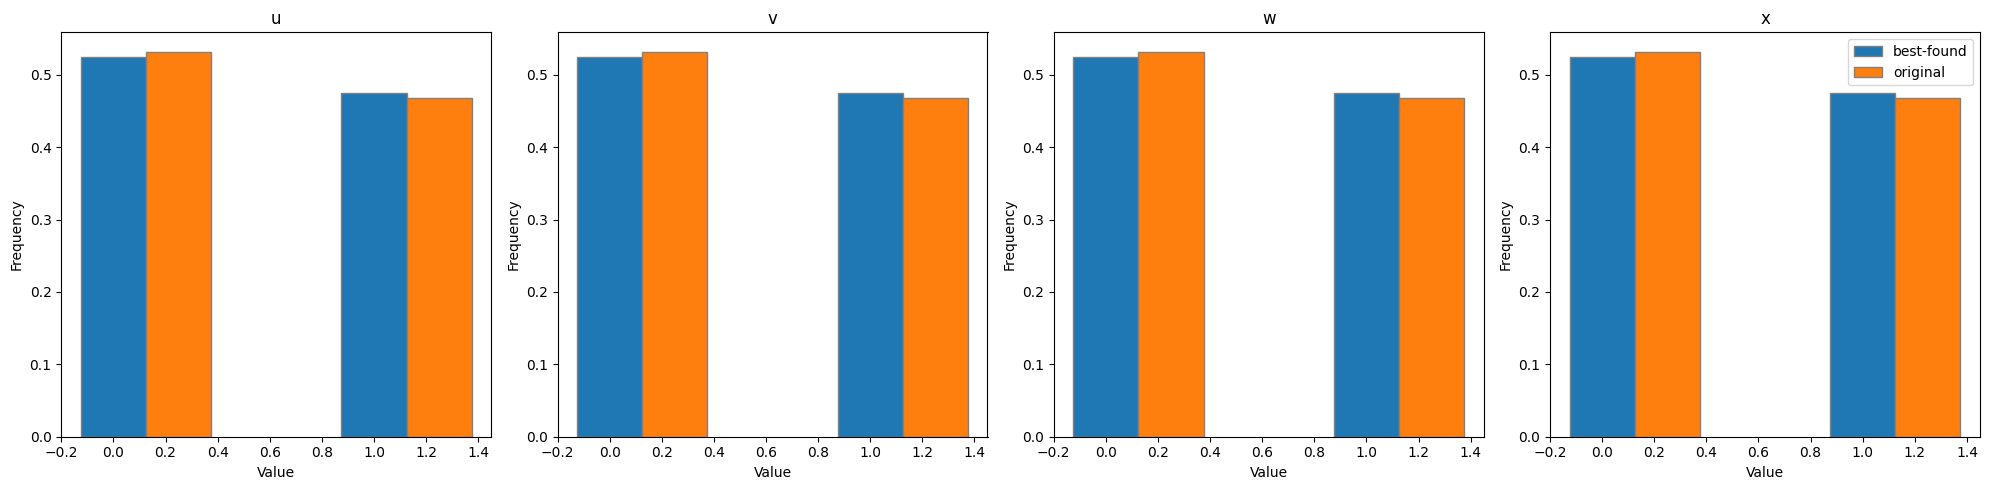

In [375]:
# histogram best found program
create_histograms([samples, data], ['best-found', 'original'], output_dist.var_list)

# Healthiness

In [2]:
model_name = 'healthiness'

### Data from the original data generating process

In [3]:
"""
def generate_healthiness_dataset(data_size):
    data = []
    for _ in range(data_size):
        healthconscius = np.random.binomial(1, 0.5)
        littlefreetime = np.random.binomial(1, 0.5)
        if healthconscius:
            if littlefreetime:
                exercise = np.random.binomial(1, 0.5)
            else:
                exercise = np.random.binomial(1, 0.9)
        else:
            if littlefreetime:
                exercise = np.random.binomial(1, 0.1)
            else:
                exercise = np.random.binomial(1, 0.5)
        if healthconscius:
            gooddiet = np.random.binomial(1, 0.7)
        else:
            gooddiet = np.random.binomial(1, 0.3)
        if gooddiet:
            if exercise:
                normalweight = np.random.binomial(1, 0.8)
            else:
                normalweight = np.random.binomial(1, 0.5)
        else:
            if exercise:
                normalweight = np.random.binomial(1, 0.5)
            else:
                normalweight = np.random.binomial(1, 0.2)
        if gooddiet:
            colesterol = np.random.binomial(1, 0.3)
        else:
            colesterol = np.random.binomial(1, 0.7)
        if colesterol:
            tested = np.random.binomial(1, 0.9)
        else:
            tested = np.random.binomial(1, 0.1)
"""

'\ndef generate_healthiness_dataset(data_size):\n    data = []\n    for _ in range(data_size):\n        healthconscius = np.random.binomial(1, 0.5)\n        littlefreetime = np.random.binomial(1, 0.5)\n        if healthconscius:\n            if littlefreetime:\n                exercise = np.random.binomial(1, 0.5)\n            else:\n                exercise = np.random.binomial(1, 0.9)\n        else:\n            if littlefreetime:\n                exercise = np.random.binomial(1, 0.1)\n            else:\n                exercise = np.random.binomial(1, 0.5)\n        if healthconscius:\n            gooddiet = np.random.binomial(1, 0.7)\n        else:\n            gooddiet = np.random.binomial(1, 0.3)\n        if gooddiet:\n            if exercise:\n                normalweight = np.random.binomial(1, 0.8)\n            else:\n                normalweight = np.random.binomial(1, 0.5)\n        else:\n            if exercise:\n                normalweight = np.random.binomial(1, 0.5)\n   

In [4]:
data = dgp.generate_dataset(model_name, 5000)
data_var_list, dependencies, weights = dgp.get_vars(model_name)

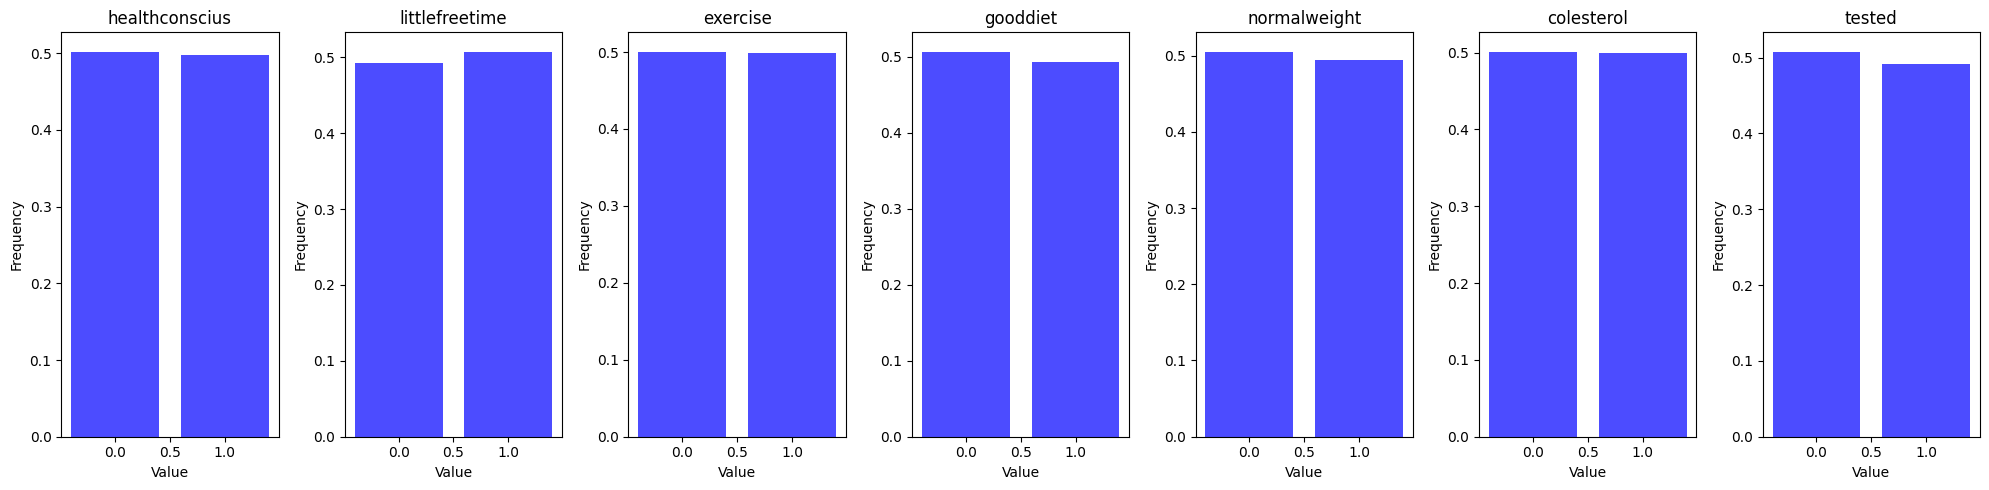

In [5]:
create_histogram(data, data_var_list)

In [6]:
file = open('C:/Users/birik/github/PonyGE2/baselines/'+model_name+'.soga', 'r')
text_baseline = ''
for line in file.readlines():
    text_baseline += line + ' '
file.close()

soga_bl = preprocess_program(text_baseline)
compiledText=compile2SOGA_text(soga_bl)
cfg = produce_cfg_text(compiledText)
output_dist_baseline = start_SOGA(cfg)

fitness_baseline = compute_likelihood(output_dist_baseline, data_var_list, data)
print(fitness_baseline)

tensor(-4.0138)


### No sketching

In [ ]:
file = open("C:/Users/birik/github/PonyGE2/results/"+model_name+"/no-sketch1/best.txt", 'r')
text_bf = ''
flag = False
for line in file.readlines():
    if 'Phenotype' in line:
        flag = True
        continue
    if 'Genotype' in line:
        flag = False
        break
    if flag:
        text_bf += line + ' '
file.close()

soga_bf = preprocess_program(text_bf)
compiledText=compile2SOGA_text(soga_bf)
cfg = produce_cfg_text(compiledText)
output_dist = start_SOGA(cfg)

fitness_bf = compute_likelihood(output_dist, data_var_list, data)
print(fitness_bf)

tensor(-inf)


In [ ]:
print('Fitness of best found program: ', fitness_bf)
print('Fitness of baseline: ', fitness_baseline)

print('Found Program \n', text_bf) 

Fitness of best found program:  tensor(-inf)
Fitness of baseline:  tensor(-1.7547)
Found Program 
 u = gm([11, 1, 0], [22, 0, 0]) + gm([1, 1, 0], [28, 0, 0]); 
  v = v + gm([25, 1, 0], [10, 0, 0]); 
  w = gm([14, 1, 0], [30, 0, 0]); 
  if u == 1 { 
    if w == 1 { 
      x = gm([8, 1, 0], [21, 0, 0]); 
    } else { 
      x = 1  * w + gm([2, 1, 0], [11, 0, 0]); 
    }end if; 
  } else { 
    if v == 1 { 
      x = gm([3, 1, 0], [1, 0, 0]); 
    } else { 
      x = x + v; 
    }end if; 
  }end if;
 
 


In [ ]:
samples = sample_gmm(output_dist, 5000)

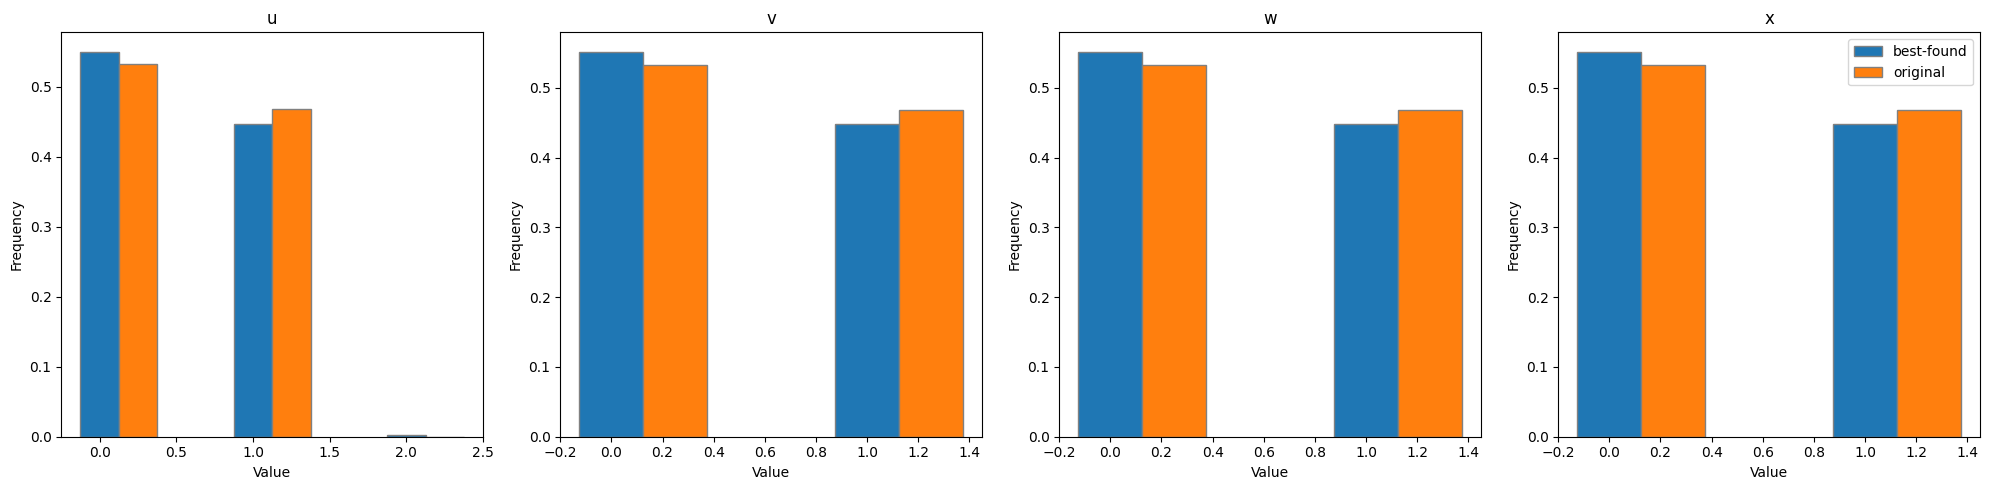

In [ ]:
# data from best found
create_histograms([samples, data], ['best-found', 'original'], output_dist.var_list)

### Sketching - no benefit

In [ ]:
file = open("C:/Users/birik/github/PonyGE2/results/"+model_name+"/sketch-noben1/best.txt", 'r')
text_bf = ''
flag = False
for line in file.readlines():
    if 'Phenotype' in line:
        flag = True
        continue
    if 'Genotype' in line:
        flag = False
        break
    if flag:
        text_bf += line + ' '
file.close()

soga_bf = preprocess_program(text_bf)
compiledText=compile2SOGA_text(soga_bf)
cfg = produce_cfg_text(compiledText)
output_dist = start_SOGA(cfg)

fitness_bf = compute_likelihood(output_dist, data_var_list, data)
print(fitness_bf)

tensor(-1.8900)


In [ ]:
print('Fitness of best found program: ', fitness_bf)
print('Fitness of baseline: ', fitness_baseline)

print('Found Program \n', text_bf) 

Fitness of best found program:  tensor(-1.8900)
Fitness of baseline:  tensor(-1.7547)
Found Program 
 u = 0  * gm([7, 1, 0], [29, 0, 0]) + gm([17, 1, 0], [29, 0, 0]); 
  v = gm([24, 1, 0], [5, 0, 0]); 
  w = gm([1, 1, 0], [24, 0, 0]); 
  if u == 1 { 
    if w == 1 { 
      x = gm([12, 1, 0], [7, 0, 0]); 
    } else { 
      x = gm([15, 1, 0], [13, 0, 0])  - x; 
    }end if; 
  } else { 
    if v == 1 { 
      x = gm([27, 1, 0], [6, 0, 0]); 
    } else { 
      x = gm([13, 1, 0], [22, 0, 0]); 
    }end if; 
  }end if;
 
 


In [ ]:
samples = sample_gmm(output_dist, 10000)

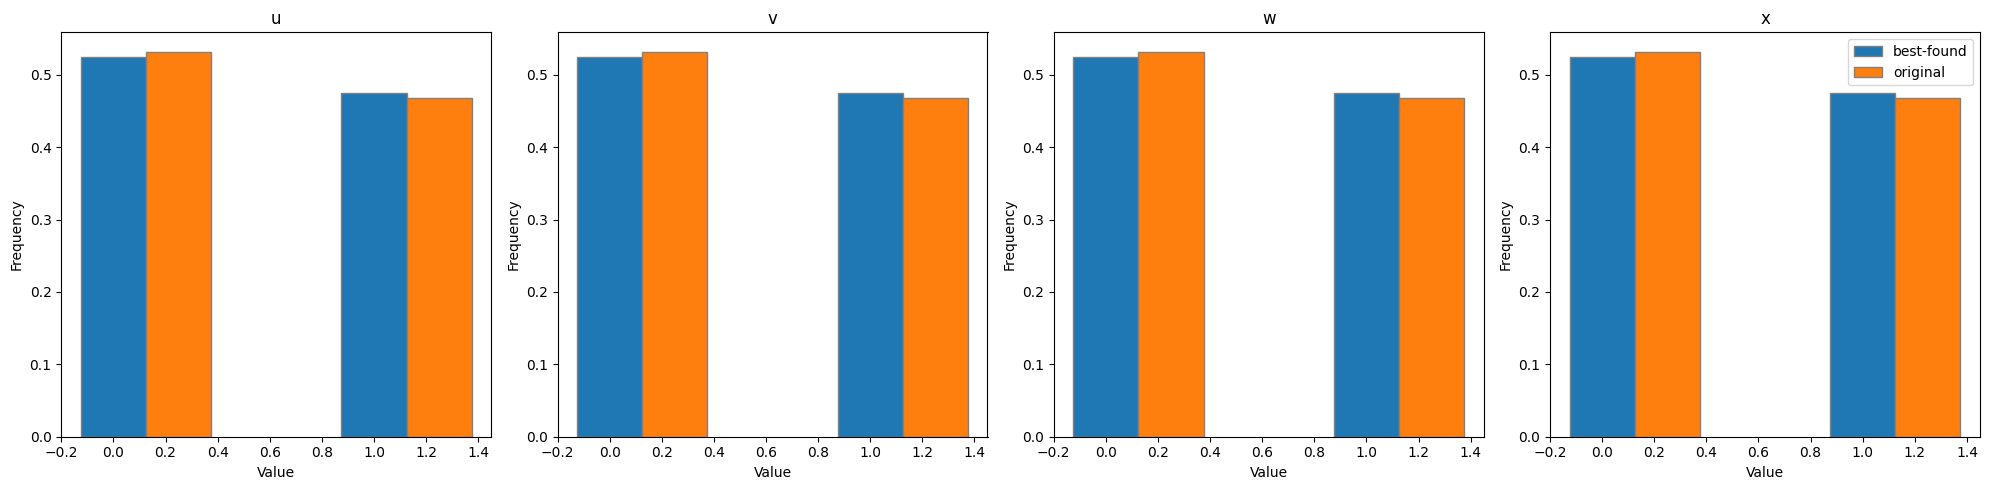

In [ ]:
# histogram best found program
create_histograms([samples, data], ['best-found', 'original'], output_dist.var_list)

# Results

In [376]:
print('NO SKETCHING \n')

models = ['burglary', 'csi']

for model_name in models:
    file = open("C:/Users/birik/github/PonyGE2/results/"+model_name+"/no-sketch1/best.txt", 'r')
    text_fitness = ''
    flag = False
    for line in file.readlines():
        if 'Fitness:' in line:
            flag = True
            continue
        if flag:
            text_fitness += line
            break
    file.close()

    print(model_name)
    print(' best fitness:', text_fitness)
    print(' baseline fitness:', fitness_baseline)

NO SKETCHING 

burglary
 best fitness: 0.0
 baseline fitness: tensor(-1.7547)
csi
 best fitness: -1.9059570749106631
 baseline fitness: tensor(-1.7547)
